# Тестовое задание
Дан видеофайл **crowd.mp4**. Нужно написать программу на языке Python, которая будет выполнять детекцию людей и их отрисовку на этом видео, проанализировать результат, сформировать рекомендации по дальнейшему улучшению. 

Результатом должен быть рабочий код программы в виде проекта, видеоролик с отрисованными людьми, выводы. 

При этом отрисовка не должна значительно перекрывать исходный кадр, детектируемые объекты должны быть различимы, а также отрисовка должна содержать имя класса и уверенность в распознавании.

In [1]:
# импорт необходимых библиотек
import torch
import cv2 as cv
from IPython.display import display, clear_output
from PIL import Image as PILImage
from io import BytesIO
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

Для данной задачи я выбрал предобученную Faster R-CNN, так как задача обработать записанное видео, а не поток + у меня есть видеокарта с поддержкой CUDA

Если бы была необходимость обрабатывать потоковое видео на процессорной мощности с приемлимой частотой кадров то выбрал бы YOLO v5/v8

Пайплайн строю из следующих допущений:
- Мы должны получить на выходе отдельное видео с детектированными людьми
- Нам не важен выходной формат (особенности моей среды вынудили переписывать в .avi)
- Время по ТЗ никак не ограничивали, поэтому созраняем разрешение и фпс

In [4]:
# функция для загрузки модели
def load_model(device: torch.device):
    '''
    Загружает предобученную fasterrcnn_resnet50_fpn, отправляет её на device и переводит в режим инференса
    IN: device: torch.device
    OUT: model: torchvision.models.detection.fasterrcnn_resnet50_fpn
    '''
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.to(device)
    model.eval()
    return model


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Начнём строить пайплайн с просмотра видео

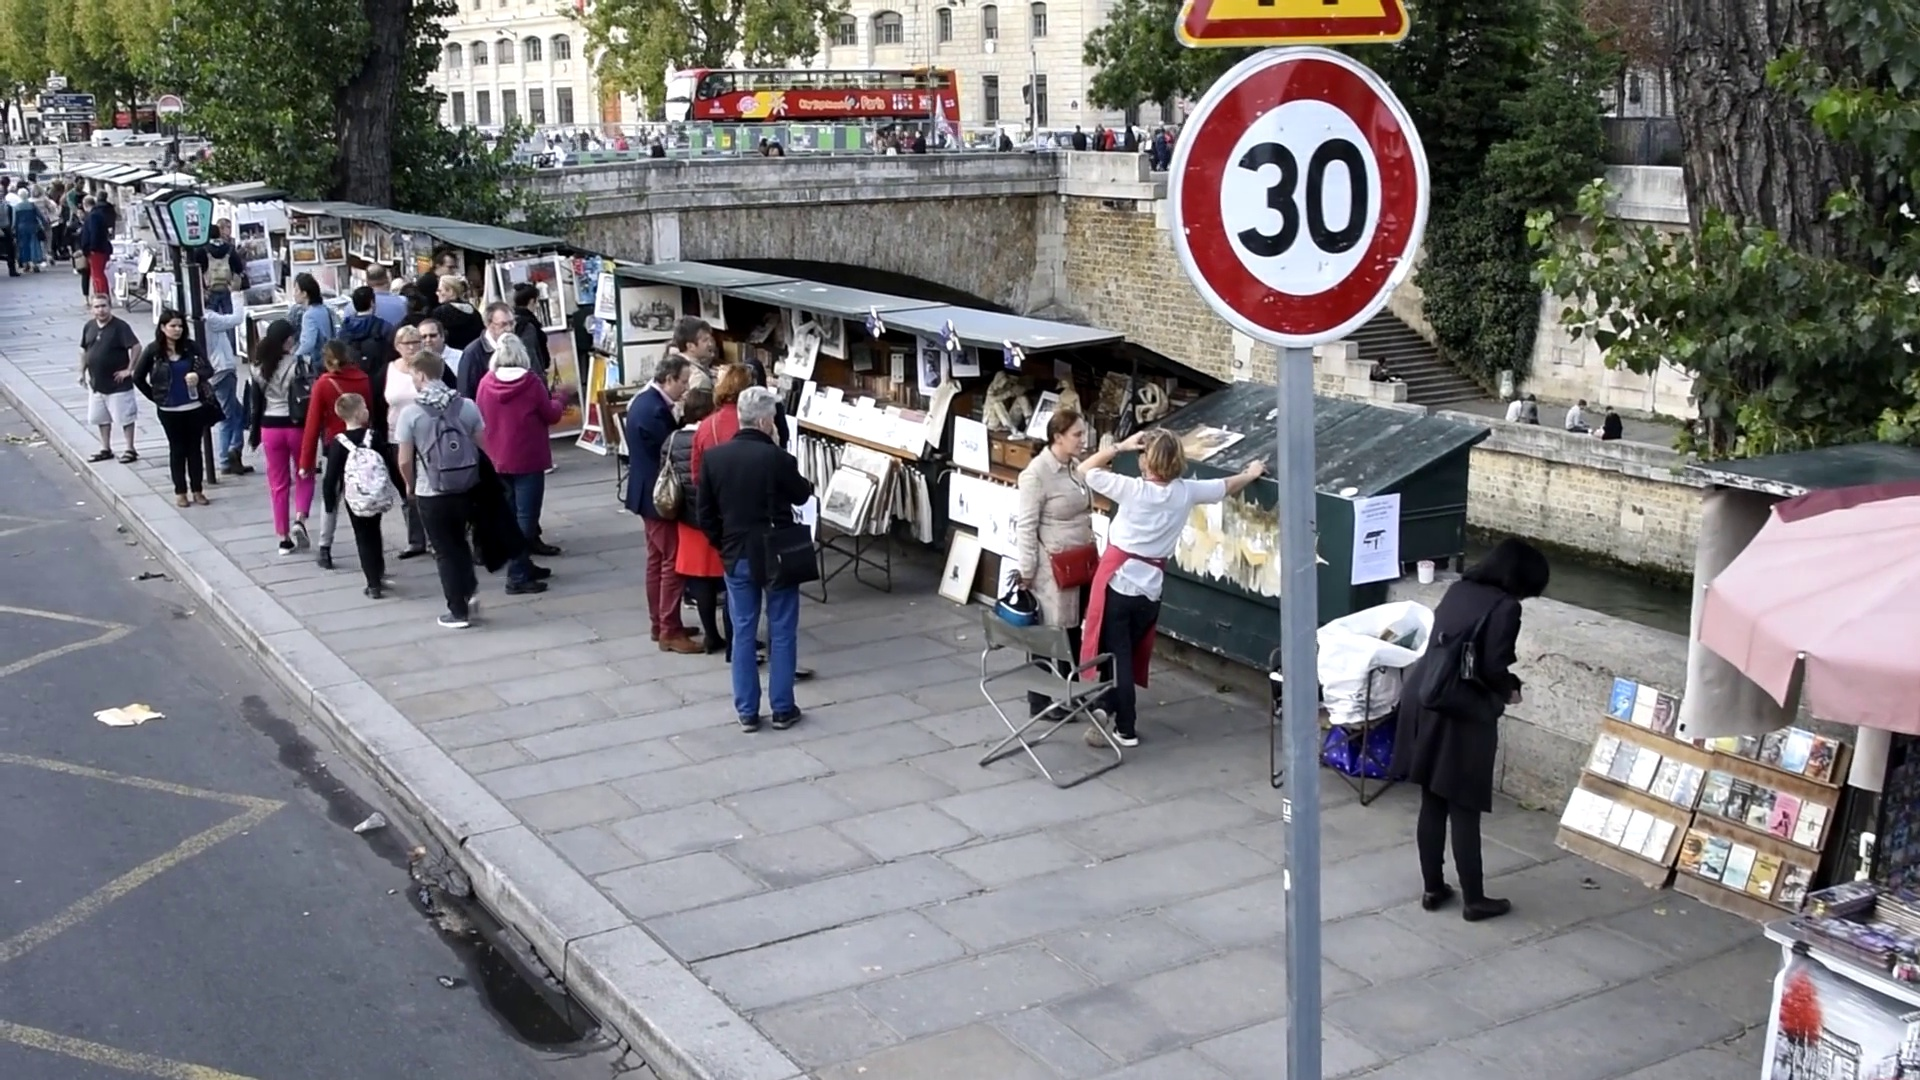

In [8]:
SOURCE_PATH = 'crowd.mp4'

cap = cv.VideoCapture(SOURCE_PATH)
if not cap.isOpened():
    print("Источник видео не открывается")
    exit() # Останавливаем выполнение ячейки

try:
    while True:
        ret, frame = cap.read()

        # Если кадр не был получен - выходим из цикла
        if not ret:
            print("Кадры закончились")
            break
        
        # костыльная секция с SOV для отображения в (по крайней мере моём) ноутбуке
        _, encoded_image = cv.imencode('.jpeg', frame)
        pil_image = PILImage.open(BytesIO(encoded_image.tobytes()))
        display(pil_image)
        clear_output(wait=True)
        
except KeyboardInterrupt:
    print("Прерывание по кнопке")

finally:
    # Освобождаем ресурсы
    cap.release()
    # cv.destroyAllWindows() # в ноутбуке не нужно

Теперь накидываем обнаружение и отрисовку баундбоксов

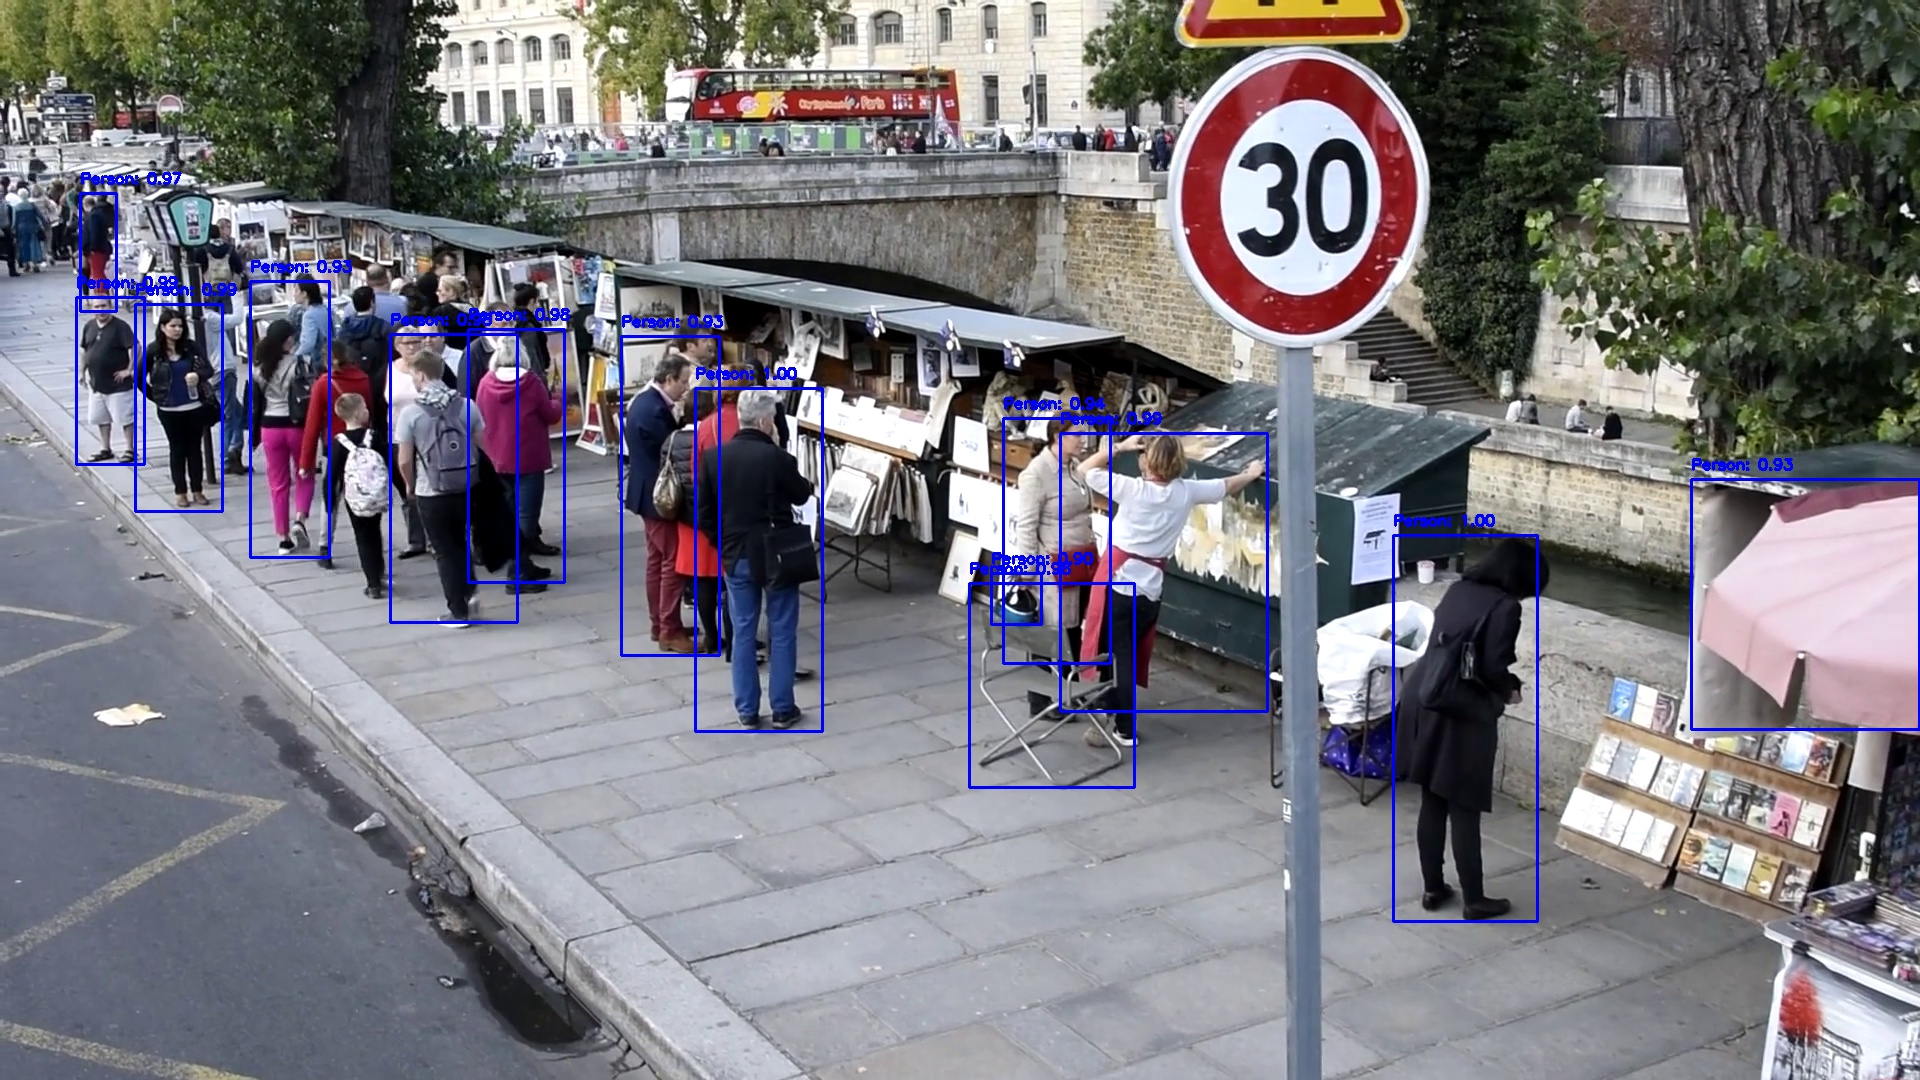

In [10]:
model = load_model(device)

cap = cv.VideoCapture(SOURCE_PATH)
if not cap.isOpened():
    print("Источник видео не открывается")
    exit() # Останавливаем выполнение ячейки

try:
    while True:
        ret, frame = cap.read()

        # Если кадр не был получен - выходим из цикла
        if not ret:
            print("Кадры закончились")
            break

        # предсказания
        tensor_frame = F.to_tensor(frame).unsqueeze(0).to(device)

        with torch.no_grad():
            preds = model(tensor_frame)

        # отрисовка (0 - class Person для COCO)
        boxes = preds[0]['boxes']
        labels = preds[0]['labels']
        scores = preds[0]['scores']

        for box, label, score in zip(boxes, labels, scores):
            if score >= 0.9:
                x_left, y_left, x_right, y_right = map(int, box)
                cv.rectangle(frame, (x_left, y_left), (x_right, y_right), (255, 0, 0), 2)
                label_text = f"Person: {score:.2f}"
                cv.putText(frame, label_text, (x_left, y_left-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # костыльная секция с SOV для отображения в (по крайней мере моём) ноутбуке
        _, encoded_image = cv.imencode('.jpeg', frame)
        pil_image = PILImage.open(BytesIO(encoded_image.tobytes()))
        display(pil_image)
        clear_output(wait=True)
        
except KeyboardInterrupt:
    print("Прерывание по кнопке")

finally:
    # Освобождаем ресурсы
    cap.release()

# Анализ полученных результатов
- при выбранном трешхолде в 0.9 модель детектирует людей только на переднем плане
- модель принимает за человека зонт и раскладное кресло на переднем фоне с вероятностью > 90%
- модель теряет людей при заходе друг за друга
- модель переодичкески накладывает рамки друг на друга
- при снижении трешхолда score до 50% процентов модель начинает различать маленьких людей и людей на заднем плане, но также принимает бОльше объектов за людей которыми таковыми не являются

Теперь необходимо добавить сохранение результата, оформить классы и функции и собрать проект

# Рекомендации по улучшению модели:
- в зависимости от конкретной задачи лучшие результаты могут показать SOTA (и не только) модели. Например YOLO v5/v8, DETR и т.д.
- всё так же в зависимости от важности детектирования людей на заднем плане можно подобрать оптимальный трпешхолд для score на отрисовку
- дообучить/обучить с нуля модель в зависимости от возможности/необходимости/целесообразности
- накинуть постобработку NMS для избегания накладывания рамок внутри одного объекта 